# Demonstrating GPU performance on synthetic data

### Overview of this notebook

This notebook demonstrates the benefit of precomputing tensors prior to model training in GPU. GPU is a througthput device, that means we get higher performance the more it is active. However, it is well known that there is a very high cost to stalling data transfer from CPU to GPU, in addition just-in-time calculations that CPU does in between batches and item retrieval further starves our expected througthput.

To overcome this, we can precompute all the tensors that the Model needs to be able to continously perform forward and backward prop with minimal delay in the GPU.

* Initial setup
* Testing on precompute = True
* Testing on default code
* Performance comparisons

### Initial setup

In [129]:
import warnings

warnings.filterwarnings("ignore")   

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss, QuantileLoss

torch.set_float32_matmul_precision("medium")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_bf16_reduced_precision_reduction = True
#torch.backends.cudnn.benchmark = False
torch.backends.cuda.matmul.allow_tf32 = True
#torch.backends.cudnn.deterministic = True

##### Create variables to store completion time

In [1]:
time_hyperopt = []
time_train = []

##### Create synthetic data

In [ ]:
data = generate_ar_data(seasonality=10.0, timesteps=100, n_series=1024*4, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()

,series,time_idx,value,static,date
0,0,0,-0.000000,2,2020-01-01
1,0,1,0.006950,2,2020-01-02
2,0,2,0.012621,2,2020-01-03
3,0,3,0.007101,2,2020-01-04
4,0,4,-0.007279,2,2020-01-05


### Testing on precompute = True

##### Intialize TimeSeriesDataSet and DataLoader

Since we are precomputing tensor here, expect that you will be incuring additional calculation time, but the benefits of approach far outweights this cost as we will see later.

Note that precomputing tensors is done in CPU at single thread only

In [127]:
# create dataset and dataloaders
max_encoder_length = 30
max_prediction_length = 10

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-HiTS can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    precompute=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 1024*8

import time

start_time = time.time()

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=False)

end_time = time.time()

print(f"DataLoader initialization time: {end_time - start_time:.6f} seconds")

torch.cuda.empty_cache()

Using precompute = True
Using precompute = True
DataLoader initialization time: 50.963802 seconds


In [4]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cuda"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)
torch.cuda.empty_cache()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cuda", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

torch.cuda.empty_cache()

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


##### Perform hyperparmeter optimization

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.004365158322401661
Restoring states from the checkpoint path at /root/work/git_proof/pytorch_forecasting/.lr_find_8bf867b4-20cc-4118-b74e-660286de51bd.ckpt
Restored all states from the checkpoint at /root/work/git_proof/pytorch_forecasting/.lr_find_8bf867b4-20cc-4118-b74e-660286de51bd.ckpt


suggested learning rate: 0.004365158322401661


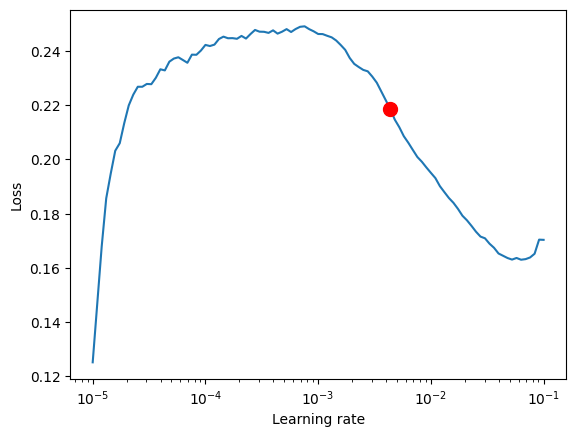

Forward Pass Time: 9.563748 seconds


In [6]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

import time

start_time = time.time()

res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

torch.cuda.synchronize() 
end_time = time.time()

completion_time = end_time - start_time

time_hyperopt.append(completion_time)

print(f"Forward Pass Time: {completion_time:.6f} seconds")

torch.cuda.empty_cache()

##### Model training

In [7]:
import torch
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    logger=False,
    max_epochs=5,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=False,
)

net = NHiTS.from_dataset(
    training,
    learning_rate=5e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

import time

start_time = time.time()
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
torch.cuda.synchronize() 
end_time = time.time()

completion_time = end_time - start_time

time_train.append(completion_time)

print(f"Forward Pass Time: {completion_time:.6f} seconds")

torch.cuda.empty_cache()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 3.5 K  | train
1 | logging_metrics | ModuleList           | 0      | train
2 | embeddings      | MultiEmbedding       | 0      | train
3 | model           | NHiTS                | 26.1 K | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Forward Pass Time: 10.913651 seconds


### Testing on old code/default @ precompute = False

##### Intialize TimeSeriesDataSet and DataLoader

What you will notice here is that the DataLoader initailization is faster than with precompute=True, this is because, when precompute=True, the precomputations of tensor is done during DataLoader initialization. This code will be extremely fast relative to the previous case.

In [128]:
# create dataset and dataloaders
max_encoder_length = 30
max_prediction_length = 10

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-HiTS can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 1024*8

import time

start_time = time.time()

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=False)

end_time = time.time()

print(f"DataLoader initalizatoin time: {end_time - start_time:.6f} seconds")

torch.cuda.empty_cache()

Using precompute = False
Using precompute = False
DataLoader initalizatoin time: 0.000158 seconds


In [9]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cuda"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)
torch.cuda.empty_cache()

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cuda", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

torch.cuda.empty_cache()

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


##### Perform hyperparmeter optimization

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0036307805477010144
Restoring states from the checkpoint path at /root/work/git_proof/pytorch_forecasting/.lr_find_88936895-de2c-4f8a-ba83-c0b898ac230e.ckpt
Restored all states from the checkpoint at /root/work/git_proof/pytorch_forecasting/.lr_find_88936895-de2c-4f8a-ba83-c0b898ac230e.ckpt


suggested learning rate: 0.0036307805477010144


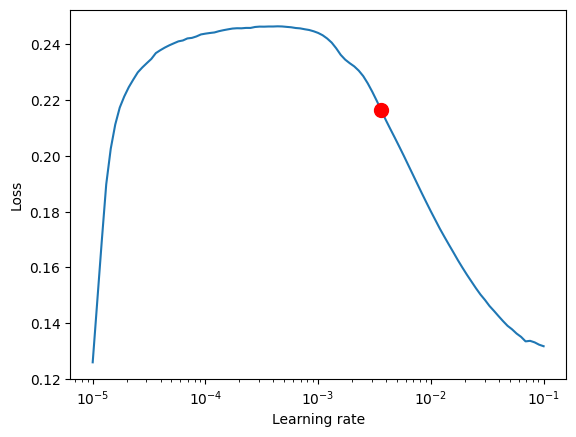

Forward Pass Time: 217.804100 seconds


In [11]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

import time

start_time = time.time()

res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

torch.cuda.synchronize() 
end_time = time.time()

completion_time = end_time - start_time

time_hyperopt.append(completion_time)

print(f"Forward Pass Time: {completion_time:.6f} seconds")

torch.cuda.empty_cache()

##### Model training

In [12]:
import torch
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    logger=False,
    max_epochs=5,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=False,
)


net = NHiTS.from_dataset(
    training,
    learning_rate=5e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

import time

start_time = time.time()
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
torch.cuda.synchronize() 
end_time = time.time()

completion_time = end_time - start_time

time_train.append(completion_time)

print(f"Forward Pass Time: {completion_time:.6f} seconds")

torch.cuda.empty_cache()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 3.5 K  | train
1 | logging_metrics | ModuleList           | 0      | train
2 | embeddings      | MultiEmbedding       | 0      | train
3 | model           | NHiTS                | 26.1 K | train
-----------------------------------------------------------------
29.6 K    Trainable params
0         Non-trainable params
29.6 K    Total params
0.118     Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Forward Pass Time: 263.333608 seconds


In [18]:
time_hyperopt = [9.563747882843018, 217.80409979820251]
time_train = [10.913650751113892, 263.333607673645]
print ("Hyperopt Time: ", time_hyperopt)
print ("Train Time: ", time_train)

Hyperopt Time:  [9.563747882843018, 217.80409979820251]
Train Time:  [10.913650751113892, 263.333607673645]


### Performance comparisons

Here, we compare the performance when precompute=True compared to the default code @ precompute=False. We compare the results from Hyperparameter Optimizations and Model training as these are where most of the time and computing resource is spent.

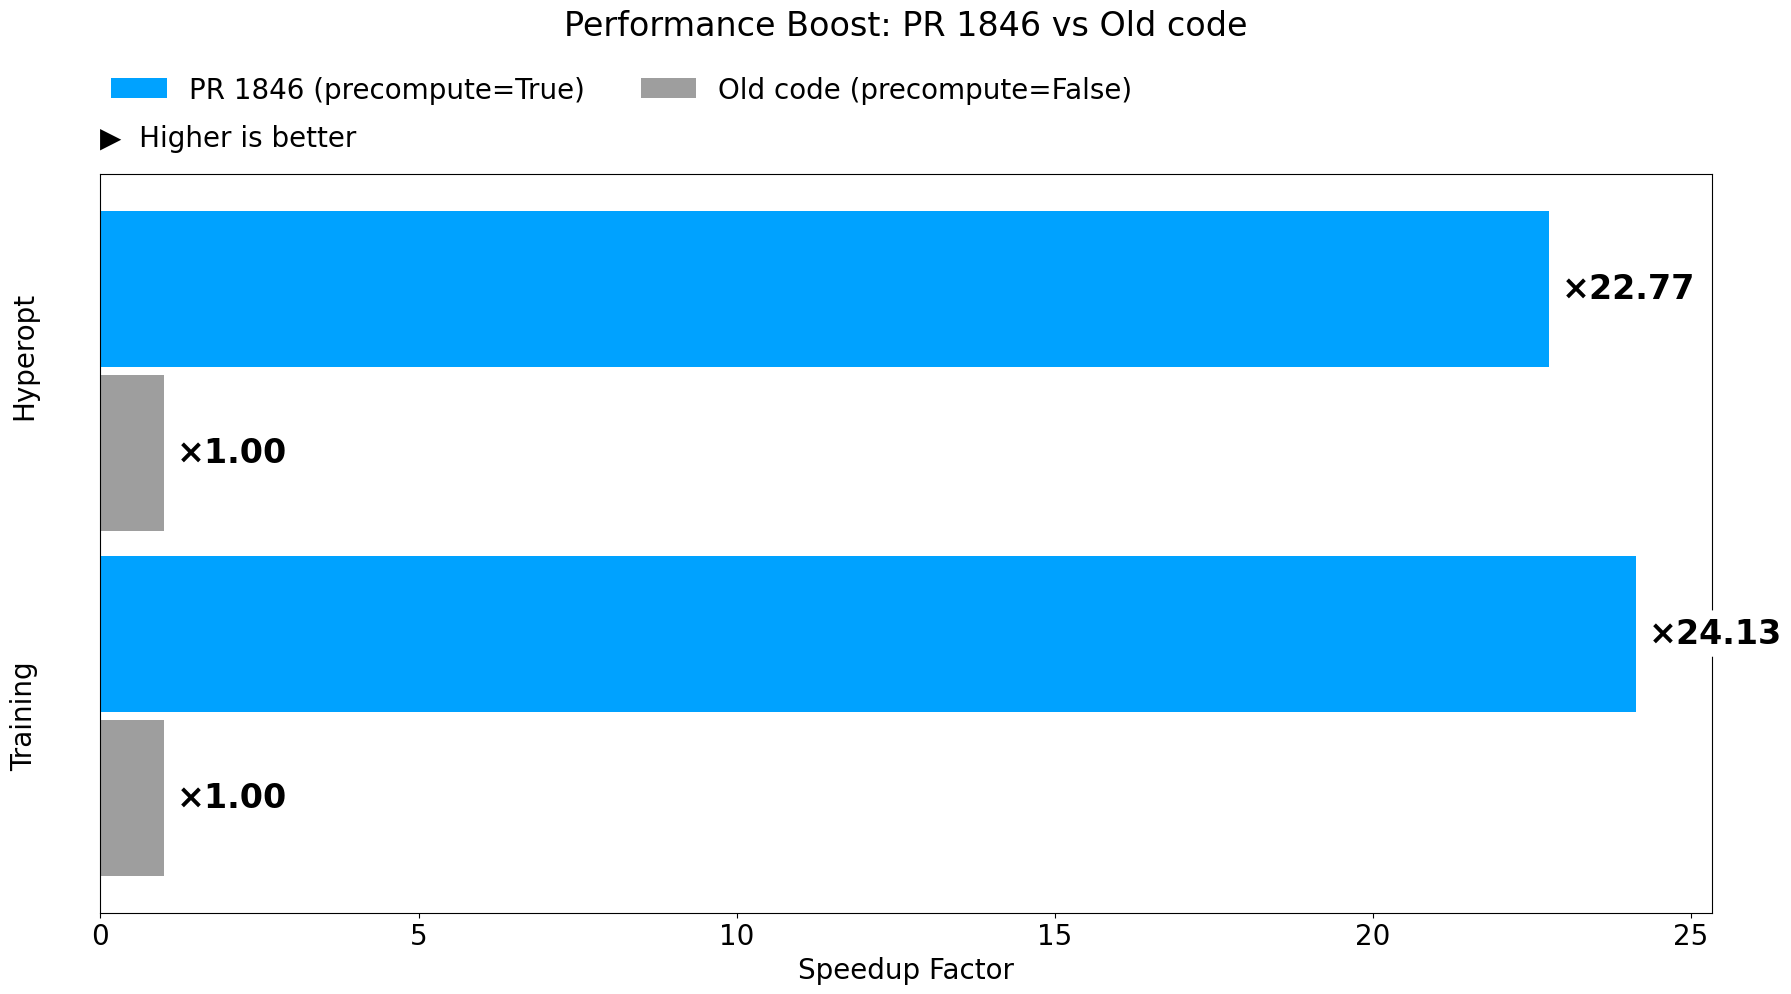

In [123]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

factor_size = 2.0

factor_hyperopt = [time_hyperopt[1] / time_hyperopt[0], 1.0]
factor_train    = [time_train[1] / time_train[0], 1.0]
factors = factor_hyperopt + factor_train

colors = ["#00a2ff", "#9e9e9e"] * 2

y_pos = [3.1, 2.1, 1.0, 0.0]

fig, ax = plt.subplots(figsize=(9*factor_size, 5*factor_size))
bars = ax.barh(y_pos, factors, color=colors, height=0.95)

fig.suptitle('Performance Boost: PR 1846 vs Old code', fontsize=12*factor_size, y=0.99)

legend_elements = [
    Patch(facecolor="#00a2ff", label='PR 1846 (precompute=True)'),
    Patch(facecolor="#9e9e9e", label='Old code (precompute=False)')
]

ax.legend(handles=legend_elements,
          bbox_to_anchor=(0, 1.08), 
          loc='lower left',
          frameon=False,
          fontsize=10*factor_size,
          ncol=2, 
          borderaxespad=0)

ax.annotate('▶  Higher is better', xy=(0, 1.03), xycoords='axes fraction',
            ha='left', va='bottom', fontsize=10*factor_size, fontweight='normal',
            color='black')


ax.set_yticks([])
ax.set_ylim(-0.7, 3.8)

ax.text(-1.2, 2.7, 'Hyperopt', rotation='vertical',
        va='center', ha='center', fontsize=10*factor_size)

ax.text(-1.2, 0.5, 'Training', rotation='vertical',
        va='center', ha='center', fontsize=10*factor_size)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.2, bar.get_y() + bar.get_height() / 2,
            f'×{width:.2f}',
            va='center', fontsize=12*factor_size, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none'))


ax.set_xlabel('Speedup Factor', fontsize=10*factor_size)
ax.tick_params(axis='x', labelsize=10*factor_size)
plt.tight_layout()
plt.show()

**Key Observations**

   - **Hyperopt Phase**: PR 1846 achieves a **22.77× speedup** over the old code.  
   - **Training Phase**: An even greater gain is observed with a **24.13× speedup**.  


When comparing PR 1846 with `precompute=True` to the old implementation, the speedup is substantial—over 22× faster during hyperparameter optimization, and even more than 24× in the training phase.

So notice, by sacrificing fraction of a time for precomputing, we can maximize the use of GPU,